# Data Exploration

Here we explore the raw data and make some cuts and aggregations in preparation for modelling.

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
!ls ../data/interim/

aq_amsterdam.csv                   regular_daily_with_derivatives.csv
openaq.db                          regular_hourly.csv
regular_daily.csv


`aq_amsterdam.csv` is the raw data, filtered on `city==Amsterdam`.

In [4]:
df_ams = pd.read_csv('../data/interim/aq_amsterdam.csv', parse_dates=True, )
df_ams['local'] = pd.to_datetime(df_ams['local'])
df_ams = df_ams.set_index('local', drop=True)
df_ams.head()

,location,city,country,utc,parameter,value,unit,latitude,longitude,attribution
local,,,,,,,,,,
2015-09-14 04:00:00,Amsterdam-Van Diemenstraat,Amsterdam,NL,2015-09-14T04:00:00.000Z,no2,16.2,Âµg/mÂ³,52.3900,4.88781,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
2015-09-14 04:00:00,Amsterdam-Kantershof (Zuid Oost),Amsterdam,NL,2015-09-14T04:00:00.000Z,no2,9.3,Âµg/mÂ³,52.3207,4.98840,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
2015-09-14 04:00:00,Amsterdam-Vondelpark,Amsterdam,NL,2015-09-14T04:00:00.000Z,no2,9.6,Âµg/mÂ³,52.3597,4.86621,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
2015-09-14 04:00:00,Amsterdam-Haarlemmerweg,Amsterdam,NL,2015-09-14T04:00:00.000Z,no2,23.6,Âµg/mÂ³,52.3854,4.87575,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
2015-09-14 04:00:00,Amsterdam-Oude Schans,Amsterdam,NL,2015-09-14T04:00:00.000Z,no2,11.0,Âµg/mÂ³,52.3721,4.90440,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."


## Data Quality

As a general rule, data quality is always bad.

#### General info

In [5]:
df_ams['location'].value_counts()

Amsterdam-Van Diemenstraat              108224
Amsterdam-Vondelpark                    108224
Amsterdam-Einsteinweg                    86534
Amsterdam-Hoogtij                        86530
Amsterdam-Stadhouderskade                65072
Amsterdam-Spaarnwoude                    65072
Amsterdam-Westerpark                     64836
Amsterdam-Nieuwendammerdijk              43384
Amsterdam-Jan van Galenstraat            43383
Amsterdam-Oude Schans                    21694
Amsterdam-Sportpark Ookmeer (Osdorp)     21694
Amsterdam-Kantershof (Zuid Oost)         21694
Amsterdam-Haarlemmerweg                  21694
Amsterdam-A10 west                       18177
Name: location, dtype: int64

In [6]:
df_ams['parameter'].value_counts()

no2     260328
pm10    191689
pm25    151823
o3       65070
co       64386
so2      42916
Name: parameter, dtype: int64

In [7]:
df_von = df_ams#[df_ams['location'] == 'Amsterdam-Van Diemenstraat']
df_von['parameter'].value_counts()

no2     260328
pm10    191689
pm25    151823
o3       65070
co       64386
so2      42916
Name: parameter, dtype: int64

#### Time series

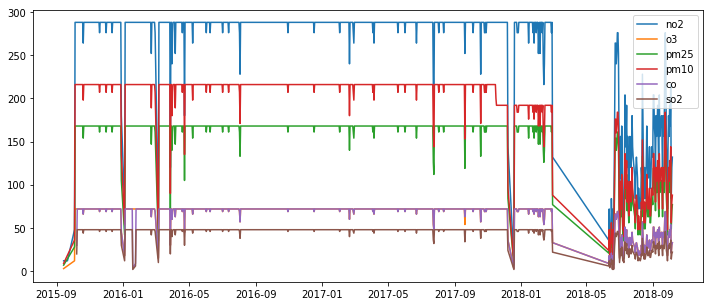

In [8]:
counts = df_ams.groupby([df_ams.index.date, df_ams['parameter']])['country'].count().reset_index(level=1)               

plt.figure(figsize=(12,5))
for param in df_ams['parameter'].unique():
    counts['country'][counts['parameter'] == param].plot(label=param)
plt.legend()

Yikes! Big change in spring 2016. Will need to remember this when validating models. Otherwise this will just a PoC that could be applied to other cities.

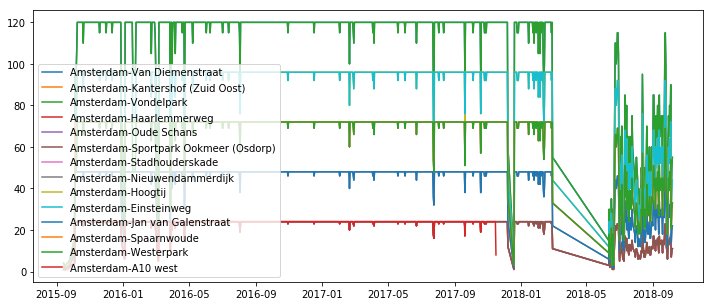

In [9]:
counts = df_ams.groupby([df_ams.index.date, df_ams['location']])['country'].count().reset_index(level=1)               

plt.figure(figsize=(12,5))
for loc in df_ams['location'].unique():
    counts['country'][counts['location'] == loc].plot(label=loc)
plt.legend(loc='lower left')

#### What to predict?

We want to predict air quality, but without a clear business need one way or the other it's up to us :) What has the best data availability?

In [10]:
df_ams.groupby('parameter')['location'].apply(lambda x: len(x.unique()))

parameter
co       3
no2     12
o3       3
pm10     9
pm25     7
so2      2
Name: location, dtype: int64

In [11]:
df_ams.groupby('location')['parameter'].apply(lambda x: list(sorted(x.unique())))

location
Amsterdam-A10 west                                         [pm10]
Amsterdam-Einsteinweg                       [co, no2, pm10, pm25]
Amsterdam-Haarlemmerweg                                     [no2]
Amsterdam-Hoogtij                          [no2, pm10, pm25, so2]
Amsterdam-Jan van Galenstraat                         [no2, pm10]
Amsterdam-Kantershof (Zuid Oost)                            [no2]
Amsterdam-Nieuwendammerdijk                             [no2, o3]
Amsterdam-Oude Schans                                       [no2]
Amsterdam-Spaarnwoude                           [no2, pm10, pm25]
Amsterdam-Sportpark Ookmeer (Osdorp)                        [no2]
Amsterdam-Stadhouderskade                       [no2, pm10, pm25]
Amsterdam-Van Diemenstraat              [co, no2, o3, pm10, pm25]
Amsterdam-Vondelpark                    [co, no2, o3, pm10, pm25]
Amsterdam-Westerpark                            [pm10, pm25, so2]
Name: parameter, dtype: object

`no2` Seems like a good choice, let's check it out!

In [12]:
df = df_ams[
    (df_ams['location'] == 'Amsterdam-Vondelpark') 
    & (df_ams['parameter'] == 'no2')
    & (df_ams.index.year.isin([2016,2017]))
].sort_index()

In [13]:
df.describe()

,value,latitude,longitude
count,16944.000000,1.694400e+04,16944.00000
mean,-748.087270,5.235970e+01,4.86621
std,440.211221,1.421127e-14,0.00000
min,-999.000000,5.235970e+01,4.86621
25%,-999.000000,5.235970e+01,4.86621
50%,-999.000000,5.235970e+01,4.86621
75%,-999.000000,5.235970e+01,4.86621
max,106.200000,5.235970e+01,4.86621


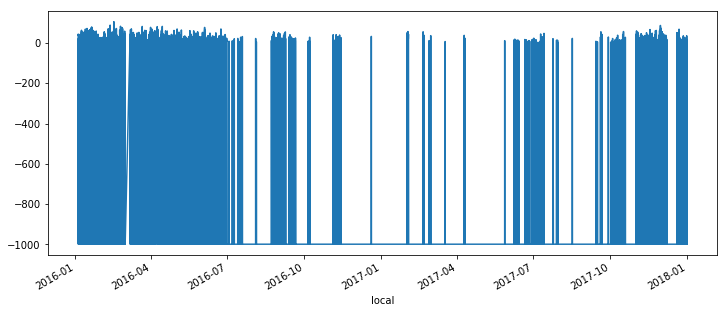

In [14]:
df['value'].plot(figsize=(12,5))

`no2` seems to have a lot of missing data. This didn't show up in the counts since apparently a sentinal value of `-999` is being used.

These quantities are all real valued, so we don't expect many entries to be equal. Let's find out what percentage of each quantity is equal to it's most frequent occuring value:

In [15]:
def highest_pct_of_total(s):
    """mode & fraction of points equal to mode"""
    m = s.mode().iloc[0]
    return pd.DataFrame(columns=['mode','frac'], data=[[m, (s == m).mean()]])
    
df_ams.groupby(['location','parameter'])['value'].apply(highest_pct_of_total).sort_values('frac')

,,,mode,frac
location,parameter,,,
Amsterdam-Jan van Galenstraat,pm10,0,-999.0,0.018028
Amsterdam-Vondelpark,pm10,0,-996.0,0.020425
Amsterdam-Hoogtij,pm10,0,-999.0,0.020886
Amsterdam-Vondelpark,pm25,0,-999.0,0.021163
Amsterdam-Van Diemenstraat,pm10,0,-999.0,0.021439
Amsterdam-Stadhouderskade,pm25,0,-999.0,0.022592
Amsterdam-Van Diemenstraat,pm25,0,-999.0,0.023330
Amsterdam-Spaarnwoude,pm10,0,-999.0,0.023560
Amsterdam-Stadhouderskade,pm10,0,-999.0,0.024114


`pm10` and `pm25` are the cear winners here. I was hoping for a good multivar time series analysis but most of this data has too much missing to be useful. We'll drop the rest of the quantities.

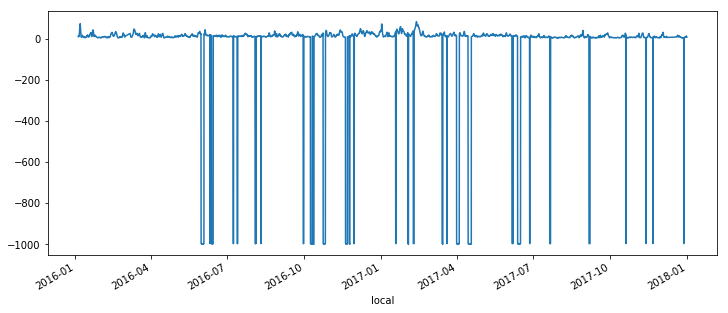

In [16]:
df = df_ams[
    (df_ams['location'] == 'Amsterdam-Westerpark') 
    & (df_ams['parameter'] == 'pm25')
    & (df_ams.index.year.isin([2016,2017]))
].sort_index()
df['value'].plot(figsize=(12,5))

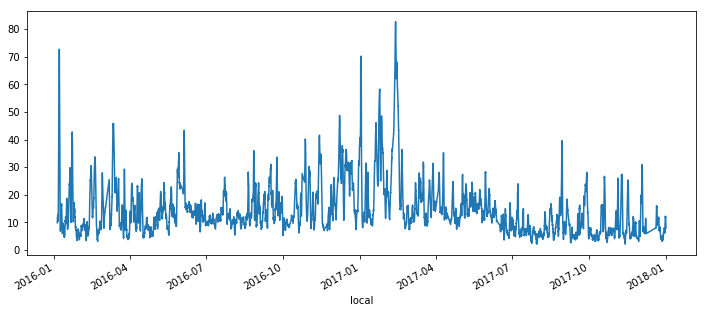

In [17]:
df[df['value'] >= 0 ]['value'].plot(figsize=(12,5))

Removing the sentinel values looks a lot better. Any major gaps?


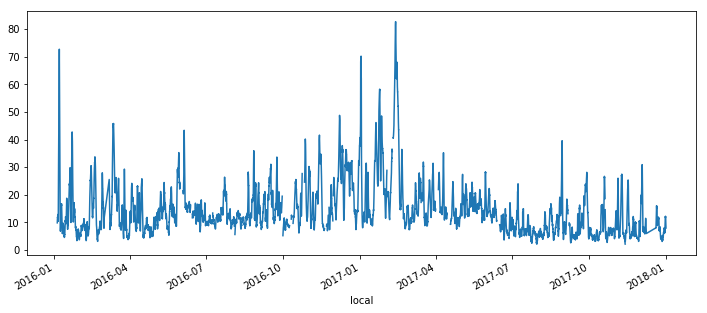

In [18]:
df.loc[df['value'] < 0, 'value'] = np.nan
df['value'].plot(figsize=(12,5));

Looks good!

In [19]:
df_ams['value'].mode()

0   -999.0
dtype: float64

## Data Selection

We decide to filter the data to: 
* `pm10` and `pm25` only
* Drop `Amsterdam-A10 west` since it also has a lot of empty data

In [20]:
df_sel = df_ams[
    (df_ams['location'] != 'Amsterdam-A10 west')
    & (df_ams['parameter'].isin(['pm10', 'pm25']))
#     & (df_ams.index.year.isin([2016,2017]))
]
df_sel = df_sel.drop(['unit', 'city', 'attribution', 'utc', 'country',], axis=1)
df_sel.describe()

,value,latitude,longitude
count,325335.000000,325335.00000,325335.000000
mean,-30.277388,52.38624,4.840177
std,214.132998,0.02178,0.057177
min,-999.000000,52.35800,4.728580
25%,8.739130,52.35970,4.773480
50%,14.241667,52.39000,4.866210
75%,21.491304,52.39840,4.887810
max,307.800000,52.42800,4.899700


In [21]:
df_sel.head()

,location,parameter,value,latitude,longitude
local,,,,,
2015-09-14 04:00:00,Amsterdam-Vondelpark,pm25,7.304167,52.3597,4.86621
2015-09-14 04:00:00,Amsterdam-Einsteinweg,pm25,10.416667,52.3813,4.84523
2015-09-14 04:00:00,Amsterdam-Van Diemenstraat,pm25,13.245833,52.3900,4.88781
2015-09-14 04:00:00,Amsterdam-Spaarnwoude,pm25,8.395833,52.3984,4.72858
2015-09-14 04:00:00,Amsterdam-Westerpark,pm25,-999.000000,52.3940,4.87016


#### Initial Preprocessing

We need to do some reshaping to get this into a workable form

In [22]:
df_piv = pd.pivot_table(
    df_sel.reset_index(drop=False),
    index=['local','location'], 
    columns='parameter',
    values='value'
)
df_piv.columns.name = None
df_piv = df_piv.reset_index().sort_values(['local','location'])
df_piv.head(25)

,local,location,pm10,pm25
0,2015-09-14 04:00:00,Amsterdam-Einsteinweg,19.633333,10.416667
1,2015-09-14 04:00:00,Amsterdam-Hoogtij,11.400000,7.445833
2,2015-09-14 04:00:00,Amsterdam-Jan van Galenstraat,14.587500,NaN
3,2015-09-14 04:00:00,Amsterdam-Spaarnwoude,12.950000,8.395833
4,2015-09-14 04:00:00,Amsterdam-Stadhouderskade,21.979167,9.558333
5,2015-09-14 04:00:00,Amsterdam-Van Diemenstraat,18.970833,13.245833
6,2015-09-14 04:00:00,Amsterdam-Vondelpark,13.629167,7.304167
7,2015-09-14 04:00:00,Amsterdam-Westerpark,14.595652,-999.000000
8,2015-10-04 20:00:00,Amsterdam-Einsteinweg,64.295833,51.533333
9,2015-10-04 20:00:00,Amsterdam-Hoogtij,59.950000,42.337500


In [23]:
df_piv.groupby('location').count()

,local,pm10,pm25
location,,,
Amsterdam-Einsteinweg,21689,21689,21689
Amsterdam-Hoogtij,21689,21689,21689
Amsterdam-Jan van Galenstraat,21689,21689,0
Amsterdam-Spaarnwoude,21689,21689,21689
Amsterdam-Stadhouderskade,21689,21689,21689
Amsterdam-Van Diemenstraat,21689,21689,21689
Amsterdam-Vondelpark,21689,21689,21689
Amsterdam-Westerpark,21689,21689,21689


`Amsterdam-Jan van Galenstraat` missing one of the quantities. We have enough other locations, let's drop it too.

In [24]:
df = df_piv[df_piv['location'] != 'Amsterdam-Jan van Galenstraat']
df = df.set_index(['local'], drop=True)

In [25]:
feats = ['pm10','pm25']
feat_df = df[feats]

All quantities shuld be positive. We remove negative values and then forward fill with the last known measurement.

In [26]:
df[feats] = df[feats].where(feat_df > 0)
df = df.groupby('location').ffill()

In [27]:
df.head()

,location,pm10,pm25
local,,,
2015-09-14 04:00:00,Amsterdam-Einsteinweg,19.633333,10.416667
2015-09-14 04:00:00,Amsterdam-Hoogtij,11.400000,7.445833
2015-09-14 04:00:00,Amsterdam-Spaarnwoude,12.950000,8.395833
2015-09-14 04:00:00,Amsterdam-Stadhouderskade,21.979167,9.558333
2015-09-14 04:00:00,Amsterdam-Van Diemenstraat,18.970833,13.245833


In [28]:
df.count()

location    151823
pm10        151823
pm25        151822
dtype: int64

In [29]:
locations = df['location'].unique()
locations

array(['Amsterdam-Einsteinweg', 'Amsterdam-Hoogtij',
       'Amsterdam-Spaarnwoude', 'Amsterdam-Stadhouderskade',
       'Amsterdam-Van Diemenstraat', 'Amsterdam-Vondelpark',
       'Amsterdam-Westerpark'], dtype=object)

## Exploration of problem

What does the input data look like after our cuts? 

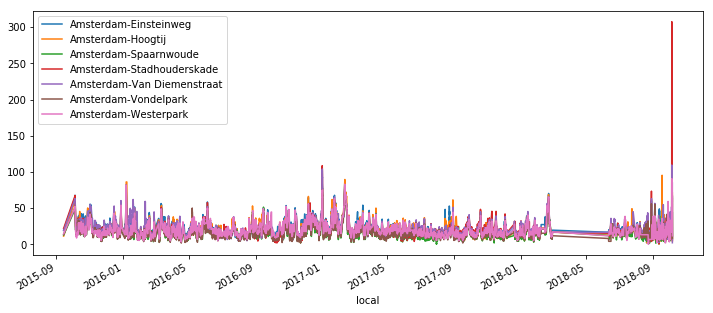

In [30]:
plt.figure(figsize=(12,5))
for loc in locations:
    df[df['location'] == loc]['pm10'].plot(label=loc)
plt.legend()

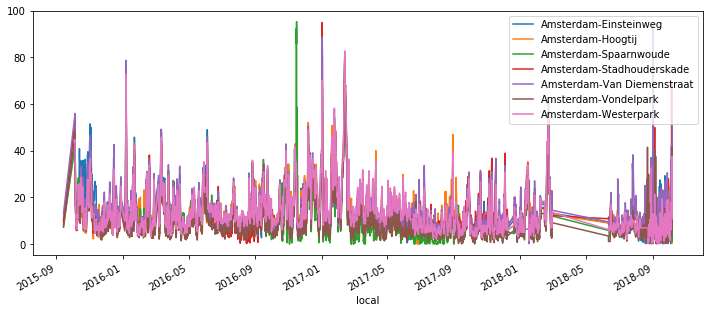

In [31]:
plt.figure(figsize=(12,5))
for loc in locations:
    df[df['location'] == loc]['pm25'].plot(label=loc)
plt.legend()

`pm10` and `pm25` look pretty similar, we can probably use them both interchangably without special treatment.

#### Time spacing

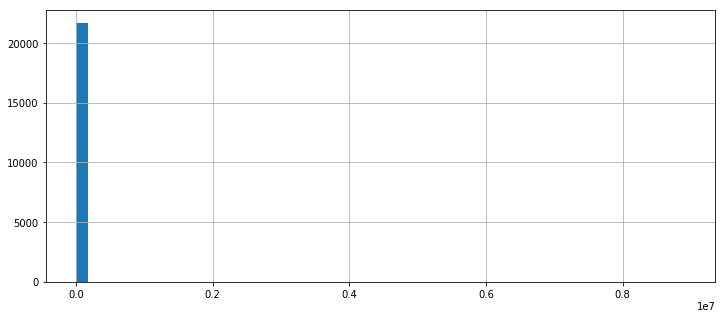

In [32]:
times = df.index.to_series().drop_duplicates()
timedeltas = times.diff()
timedeltas.dt.total_seconds().hist(bins=50, figsize=(12,5))

In [33]:
timedeltas.describe()

count                     21688
mean     0 days 01:14:16.676503
std      0 days 17:18:06.258815
min             0 days 01:00:00
25%             0 days 01:00:00
50%             0 days 01:00:00
75%             0 days 01:00:00
max           103 days 03:00:00
Name: local, dtype: object

Data is mostly spaced hourly. Let's resample to get even spacings.

In [34]:
def make_hourly(df):
    return df.resample('1h').mean().ffill()

df_reg = df.groupby('location').apply(make_hourly).reset_index(level=0)
df_reg = df_reg.groupby('location').ffill()

In [35]:
df_reg.head()

,location,pm10,pm25
local,,,
2015-09-14 04:00:00,Amsterdam-Einsteinweg,19.633333,10.416667
2015-09-14 05:00:00,Amsterdam-Einsteinweg,19.633333,10.416667
2015-09-14 06:00:00,Amsterdam-Einsteinweg,19.633333,10.416667
2015-09-14 07:00:00,Amsterdam-Einsteinweg,19.633333,10.416667
2015-09-14 08:00:00,Amsterdam-Einsteinweg,19.633333,10.416667


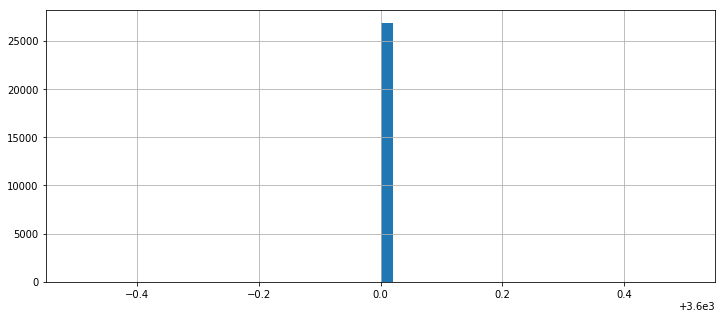

In [36]:
times = df_reg.index.to_series().drop_duplicates()
timedeltas = times.diff()
timedeltas.dt.total_seconds().hist(bins=50, figsize=(12,5))

In [37]:
df_reg.count()
df_reg.count()

location    187950
pm10        187950
pm25        187454
dtype: int64

#### Periodic behavior

Autocorrelation shoud reveal strong daily or weekyl trends

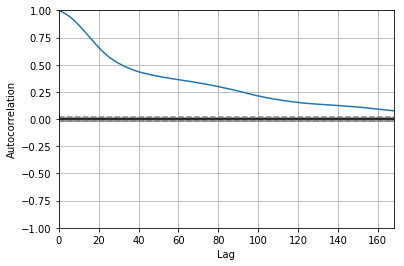

In [38]:
pd.plotting.autocorrelation_plot(df[df['location']=='Amsterdam-Vondelpark']['pm10'])
plt.xlim([0,7*24]);

Nothing! This is quite surprising to me.

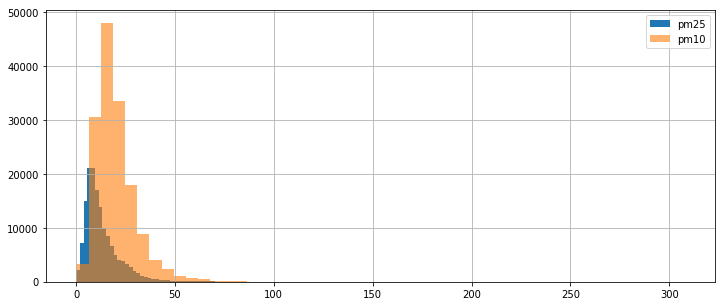

In [39]:
plt.figure(figsize=(12,5))
df['pm25'].hist(label='pm25', bins=50)
df['pm10'].hist(alpha=0.6, label='pm10', bins=50)
plt.legend()

#### Timescales

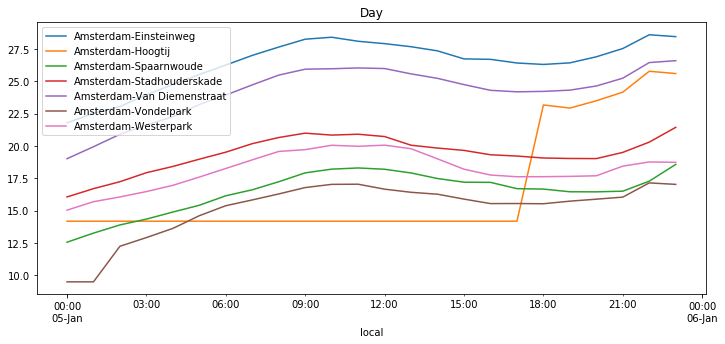

In [40]:
plt.figure(figsize=(12,5))
for loc in locations:
    df_reg[df_reg['location'] == loc]['pm10']['2016-01-05'].plot(label=loc)
plt.title('Day')
plt.legend()

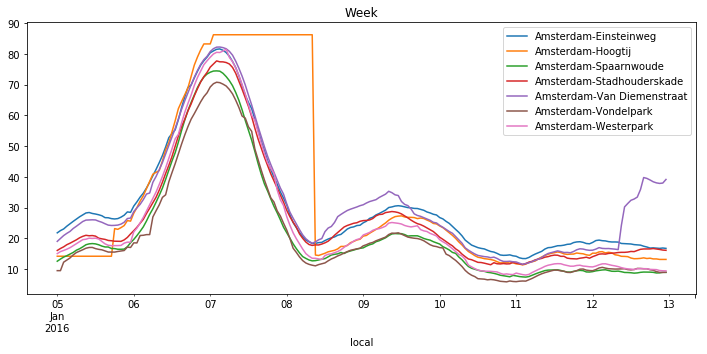

In [41]:
plt.figure(figsize=(12,5))
for loc in locations:
    df_reg[df_reg['location'] == loc]['pm10']['2016-01-05':'2016-01-12'].plot(label=loc)
plt.title('Week')
plt.legend()

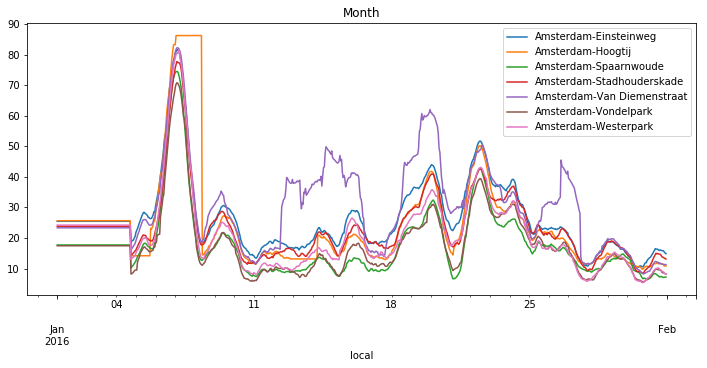

In [42]:
plt.figure(figsize=(12,5))
for loc in locations:
    df_reg[df_reg['location'] == loc]['pm10']['2016-01'].plot(label=loc)
plt.title('Month')
plt.legend()

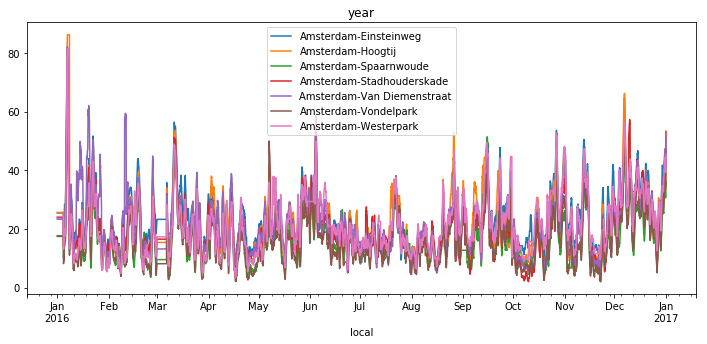

In [43]:
plt.figure(figsize=(12,5))
for loc in locations:
    df_reg[df_reg['location'] == loc]['pm10']['2016'].plot(label=loc)
plt.title('year')
plt.legend()

The relevant time scale seems to be days. I'll save an hourly version and a daily version, but hourly doesn't provide much variation.

In [44]:
df_reg.count()

location    187950
pm10        187950
pm25        187454
dtype: int64

In [45]:
df_reg.to_csv('../data/interim/regular_hourly.csv')

In [46]:
def make_daily(df):
    return df.resample('1d').mean().ffill()

df_daily = df.groupby('location').apply(make_daily).reset_index(level=0)

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
df_reg.columns

Index(['location', 'pm10', 'pm25'], dtype='object')

### Extra feature: Daily slope

Since there can be some intra-day variation, we get the slope of the values per day and add them to the daily aggregated data. 

**TODO:** Look into getting even more features using a time series feature extractor like `tsfresh`, or by hand.

In [49]:
def col_slope(col):
    x = np.arange(col.shape[0]).reshape(-1,1)
    y = col.values.reshape(-1,1)
    lr = LinearRegression().fit(x,y)
    return float(lr.coef_)

def slope(df):
    return df.apply(col_slope)

def daily_slope(df):
    reg = df.resample('1d').apply(col_slope)
    return reg

df_daily_der = df_reg.groupby('location').apply(daily_slope).reset_index()
df_daily_der = df_daily_der.rename(columns={'pm10':'pm10_der', 'pm25':'pm25_der'})

/Users/johnpaton/personal/air-quality/venv/air-quality/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [50]:
df_daily_der.head()

,location,local,pm10_der,pm25_der
0,Amsterdam-Einsteinweg,2015-09-14,0.0,2.294304e-32
1,Amsterdam-Einsteinweg,2015-09-15,0.0,0.000000e+00
2,Amsterdam-Einsteinweg,2015-09-16,0.0,0.000000e+00
3,Amsterdam-Einsteinweg,2015-09-17,0.0,0.000000e+00
4,Amsterdam-Einsteinweg,2015-09-18,0.0,0.000000e+00


In [51]:
df_daily_with_der = df_daily.reset_index().merge(df_daily_der, on=['local','location']).set_index('local', drop=True)

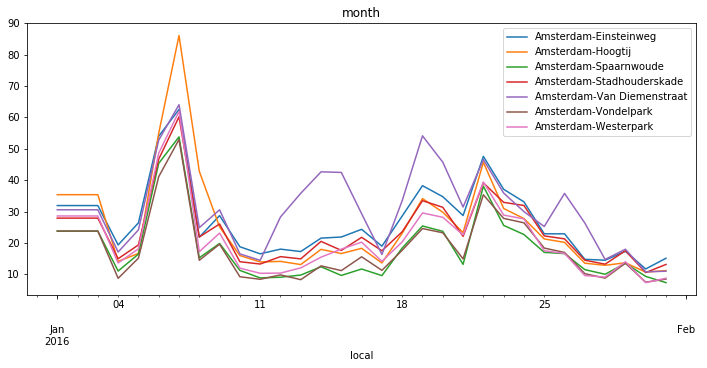

In [52]:
plt.figure(figsize=(12,5))
for loc in locations:
    df_daily[df_daily['location'] == loc]['pm10']['2016-01'].plot(label=loc)
plt.title('month')
plt.legend()

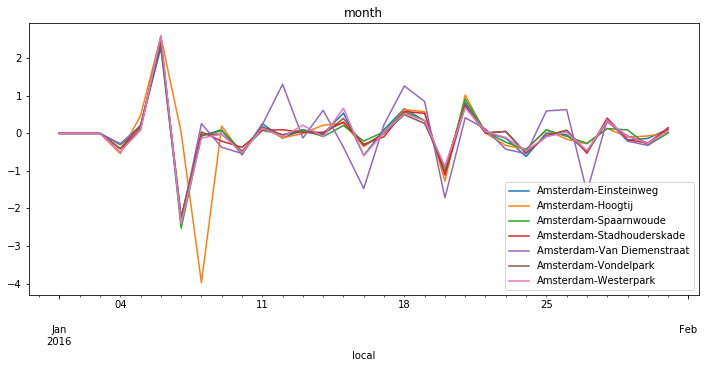

In [53]:
plt.figure(figsize=(12,5))
for loc in locations:
    df_daily_with_der[df_daily_with_der['location'] == loc]['pm10_der']['2016-01'].plot(label=loc)
plt.title('month')
plt.legend()

Looks good!

In [54]:
df_daily.to_csv('../data/interim/regular_daily.csv')

In [55]:
df_daily_with_der.to_csv('../data/interim/regular_daily_with_derivatives.csv')